In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [3]:
# function to concat the data
def concat_data(positive_file_name, negative_file_name):
    df_positive = pd.read_csv(positive_file_name)
    df_negative = pd.read_csv(negative_file_name)
    # Concatenate the data
    n_rows = df_positive.shape[0]
    df_negative_sampled = df_negative.sample(n=n_rows, random_state=42)
    df_combine = pd.concat([df_positive, df_negative_sampled])
    return df_combine

In [4]:
df_train = concat_data("2022_TP_total.csv", "2022_FP_total.csv")

In [10]:
df_test = concat_data("2021_TP_total.csv", "2021_FP_total.csv")

In [11]:
# function to preprocess the data
def preprocess_data(df):
    # Convert the 'lightning' column to a binary variable: 1 for lightning occurrence and 0 for no lightning occurrence
    df["lightning"] = (df["lightning"] > 0).astype(int)

    # abs() the 'v10' and 'u10' columns
    df["v10"] = df["v10"].abs()
    df["u10"] = df["u10"].abs()

    # Drop the 'time' column
    df = df.drop(["time", "valid_time", "local_time", "season"], axis=1)

    # Drop columns which names contain '60'
    df = df.loc[:, ~df.columns.str.contains("60")]

    # Drop all columns which names contain 'after', except it contains 'shsr' AND 'after'
    cols_contains_after = df.filter(regex="after").columns
    cols_shsr_after = df.filter(regex="SHSR.*after").columns
    cols_to_drop = [col for col in cols_contains_after if col not in cols_shsr_after]
    df = df.drop(columns=cols_to_drop)

    return df

In [12]:
df_train=preprocess_data(df_train)
df_test=preprocess_data(df_test)


In [13]:
# keep SHSR, weather and prev lightning related columns
def keep_shsr_weather_columns(df):
    weather = ["tcc", "v10", "u10", "t2m", "d2m", "ws"]
    # location = ["latitude", "longitude"]
    lightning = ["lightning_at", "lightning_prev"]
    keywords = ["shsr"]
    for col in df.columns:
        if not any(keyword in col.lower() for keyword in keywords):
            df = df.drop(col, axis=1)
    return df

In [14]:
Y_train = df_train["lightning"]
Y_test = df_test["lightning"]

In [16]:
X_train = keep_shsr_weather_columns(df_train)
X_test = keep_shsr_weather_columns(df_test)

In [17]:
# convert the column name to the list
feature_columns = X_train.columns.tolist()
print(feature_columns)

['avg_SHSR_mean', 'avg_SHSR_std', 'avg_SHSR_ct', 'avg_SHSR_diff', 'avg_SHSR_above_30_ct', 'avg_SHSR_above_40_ct', 'avg_SHSR_above_50_ct', 'sum_SHSR_mean', 'sum_SHSR_std', 'sum_SHSR_ct', 'sum_SHSR_diff', 'sum_SHSR_above_30_ct', 'sum_SHSR_above_40_ct', 'sum_SHSR_above_50_ct', 'std_SHSR_mean', 'std_SHSR_std', 'std_SHSR_ct', 'std_SHSR_diff', 'std_SHSR_above_30_ct', 'std_SHSR_above_40_ct', 'std_SHSR_above_50_ct', 'min_SHSR_mean', 'min_SHSR_std', 'min_SHSR_ct', 'min_SHSR_diff', 'min_SHSR_above_30_ct', 'min_SHSR_above_40_ct', 'min_SHSR_above_50_ct', 'max_SHSR_mean', 'max_SHSR_std', 'max_SHSR_ct', 'max_SHSR_diff', 'max_SHSR_above_30_ct', 'max_SHSR_above_40_ct', 'max_SHSR_above_50_ct', 'avg_SHSR_mean_prev_4hr_sum', 'avg_SHSR_mean_after_2hr_sum', 'avg_SHSR_mean_after_4hr_sum', 'avg_SHSR_std_prev_4hr_sum', 'avg_SHSR_std_after_2hr_sum', 'avg_SHSR_std_after_4hr_sum', 'avg_SHSR_ct_prev_4hr_sum', 'avg_SHSR_ct_after_2hr_sum', 'avg_SHSR_ct_after_4hr_sum', 'avg_SHSR_diff_prev_4hr_sum', 'avg_SHSR_diff_af

In [19]:
train_data = lgb.Dataset(X_train, label=Y_train)
test_data = lgb.Dataset(X_test, label=Y_test, reference=train_data)

In [20]:
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 31,
    "learning_rate": 0.01,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": 0,
}

In [31]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=2500,
    valid_sets=[train_data, test_data],
    valid_names=["train", "eval"],
    callbacks=[lgb.early_stopping(stopping_rounds=10)],
)

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[2500]	train's binary_logloss: 0.3207	eval's binary_logloss: 0.338614


In [32]:
# Predict the test set
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# Convert the predicted probabilities into binary
y_pred_class = np.where(y_pred >= 0.5, 1, 0)

In [23]:
print("Unique values in Y_train:", Y_train.unique())
print("Unique values in Y_test:", Y_test.unique())

Unique values in Y_train: [1 0]
Unique values in Y_test: [1 0]


In [34]:
# Evaluation
accuracy = accuracy_score(Y_test, y_pred_class)
precision = precision_score(Y_test, y_pred_class)
recall = recall_score(Y_test, y_pred_class)
f1 = f1_score(Y_test, y_pred_class)

# Calculate the confusion matrix to compute FAR and POD
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_class).ravel()

# False Alarm Ratio (FAR) - proportion of false positives among all positive forecasts
FAR = fp / (fp + tp) if (fp + tp) > 0 else 0

# Probability Of Detection (POD) - proportion of correctly predicted positive observations to all actual positives
POD = tp / (tp + fn) if (tp + fn) > 0 else 0

# Print the evaluation results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"FAR: {FAR}")
print(f"POD: {POD}")    

# Confusion Matrix
cm = confusion_matrix(Y_test, y_pred_class)
print("Confusion Matrix:")
print(cm)

Accuracy: 0.8539856220065843
Precision: 0.8533722776398787
Recall: 0.8811930606104205
F1 Score: 0.8670595596382867
FAR: 0.1466277223601213
POD: 0.8811930606104205
Confusion Matrix:
[[393640  85241]
 [ 66887 496102]]


Text(0.5, 1.0, 'LightGBM')

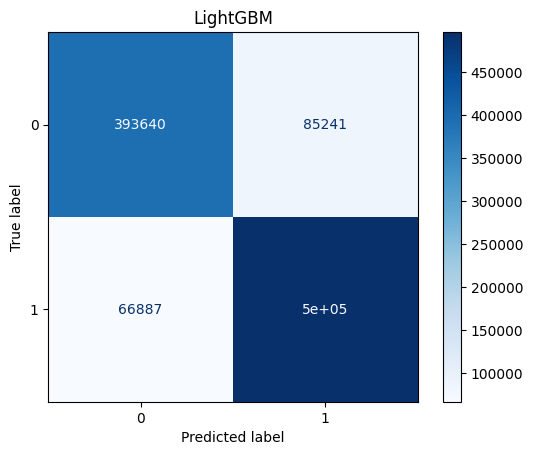

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("LightGBM")

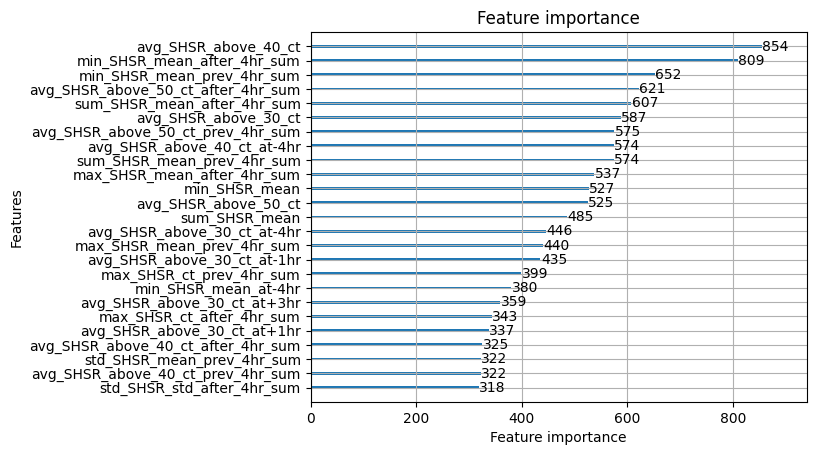

In [21]:
# Feature Importance Plot
lgb.plot_importance(gbm, max_num_features=25, importance_type="split")
plt.show()

In [22]:
# SHAP analysis
import shap

# Create an explainer object
explainer = shap.Explainer(gbm)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
